0.75
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpuqfa3o4b/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0.5, 0, '% survive')

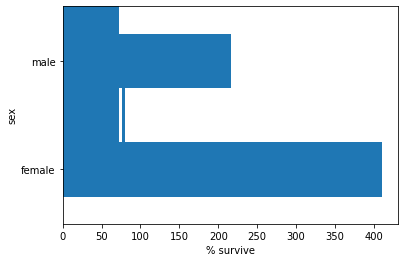

In [3]:
# !pip install -q sklearn
# %tensorflow_version 2.x

from __future__ import absolute_import, division, print_function, unicode_literals 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from IPython.display import clear_output 
from six.moves import urllib 

import tensorflow.compat.v2.feature_column as fc 

import tensorflow as tf 


dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')





# Removing the dependent variable from test and training data and adding it to these variables. 
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')







# Data Visualizations 
# dftrain.age.hist(bins=20)

# dftrain.sex.value_counts().plot(kind='barh')

# dftrain['class'].value_counts().plot(kind='barh')

# pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')







#  Now we need to create our features list 
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))






# define the input function - 10 epochs, model data will be streamed into it in small batches of 32. 

def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function(): # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df)) # create tf.data.Datset object with data and its label 
    if shuffle:
      ds = ds.shuffle(1000) #randomize order of data 
    ds = ds.batch(batch_size).repeat(num_epochs) # split dataset into batches of 32 and repear process 10 times since we have 10 epochs 
    return  ds #reutn a batch of the dataset 
  return input_function #return a function object for use 

train_input_fn = make_input_fn(dftrain, y_train) # here we will call the input function that was returned to us to get a dataset object that we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)






# Creating the model 

# I am going to use a linear estimator to utilize the linear regression algorithm 
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# I pass in the feature columns we created above. 







# Training the model 
linear_est.train(train_input_fn) # train
result = linear_est.evaluate(eval_input_fn)


clear_output()
print(result['accuracy'])


pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

#Results visualizations 

dftrain.age.hist(bins=20)
dftrain.sex.value_counts().plot(kind='barh')
dftrain['class'].value_counts().plot(kind='barh')
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')


# Females had a much higher chance of survival 

